In [1]:
import numpy as np
from sklearn.decomposition import PCA
import myfun as mf
import os
import copy

import matplotlib as mpl
from matplotlib import rc, gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches

rc('font', **{'family':'serif','serif':['Palatino']})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}') 

In [2]:
###### load stuff #######
datdir  = 'sn1'
m2 = 3
m1s       = np.load('{0}/m1s.npy'.format(datdir))
gexp      = np.load('{0}/gexp.npy'.format(datdir))
alphas    = np.load('{0}/alphas.npy'.format(datdir))
drv_idxs  = np.load('{0}/driv_idxs.npy'.format(datdir))

dtraj     = np.load('tc_traj/dtraj.npy'.format(datdir))

#######trajectory processing #######
nm1, ncells, ngenes = gexp.shape
nresp = alphas.shape[0]

nidxs = np.where(alphas<0.5)[0]
pidxs = np.where(alphas>0.5)[0]

xidxs = np.where(drv_idxs==0)[0]
yidxs = np.where(drv_idxs==1)[0]

xnidxs = np.intersect1d(nidxs, xidxs)
xpidxs = np.intersect1d(pidxs, xidxs)
ynidxs = np.intersect1d(nidxs, yidxs)
ypidxs = np.intersect1d(pidxs, yidxs)

gexp_mu  = np.mean(gexp,axis=1)
gexp_qi  = np.quantile(gexp,axis=1,q=[0.025,0.975])
gexp_err = np.std(gexp,axis=1)#/np.sqrt(ncells) #np.abs(gexp_qi-gexp_mu)

###### eigenvalue calculation ########
gexps        = np.array([gexp]) # this is because of the pitchfork clustering
gexps_mu     = np.mean(gexps,axis=2)
gexps_cent   = (gexps.transpose((2,0,1,3))-gexps_mu).transpose((1,2,0,3))
sds          = np.std(gexps_cent, axis=2, ddof=1)
covs         = np.array([[np.cov(gexps_cent[i,t].T) for t in range(nm1)] for i in range(gexps.shape[0])])

cov_eig    = [[np.linalg.eig(cov[t]) for t in np.arange(nm1)] for cov in covs]
cov_evals  = np.array([[cov_eig[i][t][0] for t in np.arange(nm1)] for i in range(len(covs))])
cov_evecs  = np.array([[cov_eig[i][t][1] for t in np.arange(nm1)] for i in range(len(covs))])

cov_evec0      = cov_evecs[...,0]
cov_evec0_sign = mf.nz_sign(mf.maxabs(cov_evec0,axis=2))
cov_evec0_ns   = np.real_if_close((cov_evec0.transpose((2,0,1)) * cov_evec0_sign).transpose((1,2,0)))

##### bifurcation pseudotime ######
bif_idxs = np.argmax(cov_evals[:,:,0],axis=1)

In [3]:
########## resampling gexp ################
print('computing null')
nt, nc, ng = gexp.shape
nsamp = 20
npc = 2
pca = PCA(n_components=npc)
gene_shuf_eig1 = np.zeros([nt, nsamp,npc])
#samp_idxs = np.random.choice(nc, size=(nt, nsamp, ))
for t in range(nt):
    gexpt = gexp[t]
    for i in range(nsamp):
        gexp_shuf = np.array([gexpt[:,g][np.random.choice(nc, nc, replace=True)] for g in range(ng)]).T
        pca.fit(gexp_shuf)
        gene_shuf_eig1[t,i]=pca.explained_variance_
#gexp.shape

null_eval_mu  = np.mean(gene_shuf_eig1,axis=1)
null_eval_err = np.std(gene_shuf_eig1,axis=1)
print('done computing null')
############################################

computing null
done computing null


In [4]:
######################################################
## calculate cos th (angle between cov-v1 and gexp)###
######################################################

v1_bif = cov_evec0[0,bif_idxs[0]]
cos_th = gexps[0].dot(v1_bif)/np.linalg.norm(gexps[0],axis=2)
cos_th_bins = np.linspace(-0.75,0.75,16)
cos_th_hist = np.array([np.histogram(cos_th[i],cos_th_bins,density=True)[0] for i in range(cos_th.shape[0])]).T
cos_th_bin_ctrs = 0.5*(cos_th_bins[1:]+cos_th_bins[:-1])

####################################################
############# jacobian calculations ################
####################################################

# there's def a bunch of extra unused code here....
dxdotdx = -1
dxdotdy = lambda m1,y: -2*m1*y/((1+y*y)**2)
dydotdy = -1
dydotdx = lambda m2,x: dxdotdy(m2,x)
dvdotdr = lambda alpha, r: 2*r*(2*alpha-1)/((1+r*r)**2)

jac_m1 = np.zeros((nm1, ncells, ngenes, ngenes))
for i in range(ngenes):
    jac_m1[:,:,i,i]=-1

jac_m1[:,:,0,1]   = dxdotdy(m1s,gexps[0,:,:,1].T).T
jac_m1[:,:,1,0]   = dxdotdy(m2,gexps[0,:,:,0])

for i in range(nresp):
    jac_m1[:,:,i+2,drv_idxs[i]] = dvdotdr(alphas[i],gexps[0,:,:,drv_idxs[i]])

jac_bif_evals, jac_bif_evecs      = np.linalg.eig(jac_m1)
jac_eig_max_idxs                  = np.argmax(jac_bif_evals,axis=2)
jac_max_eval     = np.max(jac_bif_evals,axis=2)
mu_jac_max_eval  = np.mean(jac_max_eval,axis=1)
std_jac_max_eval = np.std(jac_max_eval,axis=1)/np.sqrt(ncells)

jac_evec0    = np.array([[jac_bif_evecs[i,j,:,jac_eig_max_idxs[i,j]]
                          for j in np.arange(jac_eig_max_idxs.shape[1])]
                         for i in np.arange(jac_eig_max_idxs.shape[0])])

errsp         = np.linalg.norm( jac_evec0.transpose((1,0,2))-cov_evec0_ns[0],axis=2)
errsn         = np.linalg.norm(-jac_evec0.transpose((1,0,2))-cov_evec0_ns[0],axis=2)
jac_evec0_sgn = (np.argmin(np.array([errsn,errsp]),axis=0)*2-1).T
jac_evec0_ns  = ((jac_evec0.transpose((2,0,1))) * jac_evec0_sgn).transpose((1,2,0))

jac_m1_muexp = np.zeros((nm1, ngenes, ngenes))
for i in range(ngenes):
    jac_m1_muexp[:,i,i]=-1

jac_m1_muexp[:,0,1]   = dxdotdy(m1s,gexps_mu[0,:,1].T).T
jac_m1_muexp[:,1,0]   = dxdotdy(m2,gexps_mu[0,:,0])

for i in range(nresp):
    jac_m1_muexp[:,i+2,drv_idxs[i]]   = dvdotdr(alphas[i],gexps_mu[0,:,drv_idxs[i]])

jac_muexp_evals, jac_muexp_evecs      = np.linalg.eig(jac_m1_muexp)
jac_muexp_maxeval_idxs                = np.argmax(jac_muexp_evals,axis=1)
jac_muexp_maxevals                    = np.max(jac_muexp_evals,axis=1)

jac_muexp_evec0     = np.array([jac_muexp_evecs[i,:,jac_muexp_maxeval_idxs[i]] for i in np.arange(nm1)])

errsp               = np.linalg.norm( jac_muexp_evec0-cov_evec0_ns[0],axis=1)
errsn               = np.linalg.norm(-jac_muexp_evec0-cov_evec0_ns[0],axis=1)
jac_muexp_evec0_sgn = (np.argmin(np.array([errsn,errsp]),axis=0)*2-1)

jac_muexp_evec0_ns  = ((jac_muexp_evec0.T) * jac_muexp_evec0_sgn).T
jac_evec_err        = np.linalg.norm(jac_muexp_evec0_ns - cov_evec0_ns[0],axis=1)

##########################################################
############### gene sorting by alpha ####################
##########################################################
xasrt = np.argsort(alphas[xidxs])
yasrt = np.argsort(alphas[yidxs])

sd_sd = np.array([np.outer(sds[0,i],sds[0,i]) for i in range(nm1)])
corrs = covs[0] / sd_sd

xcorrs = corrs[:,0,xidxs[xasrt]+2]
ycorrs = corrs[:,1,yidxs[yasrt]+2]

xalphas = alphas[xidxs[xasrt]]
yalphas = alphas[yidxs[yasrt]]


yastr = ['{0:.2f}'.format(i) for i in yalphas]
xastr = ['{0:.2f}'.format(i) for i in xalphas]


# both together...
asrt     = np.argsort(alphas)
rgidxs   = np.arange(2,ngenes)[asrt]
xycorrs  = np.array([corrs[:,drv_idxs[i-2],i] for i in rgidxs]).T
xyalphas = alphas[asrt]
xyastr   = ['{0:.2f}'.format(i) for i in xyalphas]

############# correlation calculations
corrsxy  = [xcorrs, ycorrs, xycorrs]
alphasxy = [xalphas, yalphas, xyalphas]
astrxy   = [xastr, yastr, xyastr]

ridx,cidx=np.tril_indices(ngenes,-1)
corr_bins = np.linspace(-1,1,21)
corr_hists = np.array([np.histogram(corrs[i,ridx,cidx],bins=corr_bins,density=True)[0]
                       for i in range(corrs.shape[0])])
corr_bin_ctrs = (corr_bins[1:]+corr_bins[:-1])*0.5

gexp_mut = gexp_mu.T

l2h_idxs = np.hstack([xpidxs,ynidxs])
h2l_idxs = np.hstack([xnidxs,ypidxs])

l2h_asrt = np.argsort(np.abs(alphas[l2h_idxs]-0.5))
h2l_asrt = np.argsort(np.abs(alphas[h2l_idxs]-0.5))

gexp_mu_sort = np.vstack([gexp_mut[[0]],
                          gexp_mut[l2h_idxs[np.flip(l2h_asrt)]+2],
                          gexp_mut[h2l_idxs[h2l_asrt]+2],
                          gexp_mut[[1]]
                         ])

gexp_mu_sort_norm = mf.norm0to1(gexp_mu_sort,1)

gexp_mu_sort2 = np.vstack([mf.norm0to1(gexp_mut[[0]],1),
                          gexp_mut[l2h_idxs[np.flip(l2h_asrt)]+2],
                          gexp_mut[h2l_idxs[h2l_asrt]+2],
                          mf.norm0to1(gexp_mut[[1]],1)
                         ])

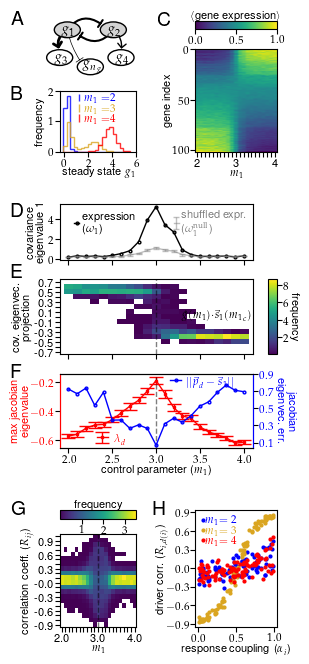

In [5]:
#######################################################
######### the figure ################################
#######################################################
plt.style.reload_library()
plt.style.use('one_col_fig')

wfrac, hfrac = 4,4
marg_ht = 1
leg_ht  = 0.5
leg_spc = 1
a_end   = 1
ab_spc  = 1.25
b_ht    = 3.25
bd_spc  = 2.75
dht     = 3
eht     = 4
fht     = 4
de_spc  = 1
ght     = 5
fg_spc  = 3.25
leg_spc2 = 0.75

marg_wd = 2.5
col1_wd = 4
ac_spc  = 3
col2_wd = 3
legspc_wd = 0.75
leg_wd = 0.5

lspace=1

# row heights
hts = np.array([

    marg_ht,
    leg_ht,
    leg_spc,
    a_end,
    ab_spc,
    b_ht,
    bd_spc,
    dht,
    de_spc,
    eht,
    de_spc,
    fht,
    fg_spc,
    leg_ht,
    leg_spc2,
    ght

])

wds = np.array([
    marg_wd,
    col1_wd,
    ac_spc,
    col2_wd,
    legspc_wd,
    leg_wd
])

hts = np.array(wfrac*hts,dtype = int)
wds = np.array(hfrac*wds,dtype = int)

rs = np.cumsum(hts) # starting rows
cs = np.cumsum(wds) # starting cols

nr = np.sum(hts)
nc = np.sum(wds)

wid = 8.7/2.54
ht  = wid*nr/nc


fig = plt.figure(figsize=(wid, ht), dpi=100)

gs = gridspec.GridSpec(nr, nc)

axA  = plt.subplot( gs[rs[0]:rs[3], cs[0]:cs[1]]) # schematic
axB  = plt.subplot( gs[rs[4]:rs[5], cs[0]:cs[1]]) # time series

axCL = plt.subplot( gs[rs[0]:rs[1], cs[2]:]) # gene expression heat map legend
axC  = plt.subplot( gs[rs[2]:rs[5], cs[2]:]) # gene expression heat map

axD  = plt.subplot( gs[rs[6]:rs[7], cs[0]:cs[3]]) # covariance eigenvalue
axE  = plt.subplot( gs[rs[8]:rs[9], cs[0]:cs[3]]) # costh
axEL = plt.subplot( gs[rs[8]:rs[9], cs[4]:     ]) # costh

axF1 = plt.subplot( gs[rs[10]:rs[11],  cs[0]:cs[3]]) # jacobian evalue /

axGL = plt.subplot( gs[rs[12]:rs[13], cs[0]:cs[1]]) # correlation legend
axG  = plt.subplot( gs[rs[14]:      , cs[0]:cs[1]]) # correlation
#axHL = plt.subplot( gs[rs[10]:rs[11], cs[2]:]) # corr distr legend
axH  = plt.subplot( gs[rs[12]:      , cs[2]:]) # cirr distr

caps = [
     'A',   'B',  'C',  'D', 'E',  'F',   'G',   'H']
ri = [rs[0],rs[4],rs[0],rs[6],rs[8],rs[10],rs[12],rs[12]]
ci = [0,    0,    cs[1],0,    0,    0,     0,     cs[1]]
xs = [0,    0,    5,    0,    0,    0,     0,     4]
ys = [0,   -1,    0,   -2,    1.5,  0,     0,     0]

for i in range(len(caps)):
    cap_ax=plt.subplot(gs[ri[i]:ri[i]+1,ci[i]:ci[i]+1])
    cap_ax.text(s=caps[i], x=xs[i], y=ys[i],fontsize=14, fontweight='bold')
    cap_ax.axis('off')

#####################################
## A: schematic                    ##
#####################################

caps = [r'$g_1$',r'$g_2$',r'$g_3$',r'$g_4$',r'$g_{n_g}$']
xs = np.array([0.2,0.8,0.1,0.9,0.5])-0.1
ys = np.array([0.8,0.8,0.2,0.2,0])
fcs = ['lightgrey']*2+['white']*3

ar0 = np.array([
    [xs[0], ys[0]],
    [xs[1], ys[1]],
    [xs[0], ys[0]],
    [xs[1], ys[1]],
    [xs[0], ys[0]]
])
arF = np.array([
    [xs[1]-0.14, ys[1]+0.1],
    [xs[0]+0.14, ys[0]-0.1],
    [xs[2],      ys[2]+0.13],
    [xs[3],      ys[3]+0.13],
    [xs[4]-0.12, ys[4]+0.1],
])
rad = np.array([-0.5,-.5,.4,-0.3,.1])
astyle = ['|-|,widthA=0,widthB=3',
         '|-|,widthA=0,widthB=3',
         '->,head_width=3,head_length=3',
         '->,head_width=3,head_length=3',
         '|-|,widthA=0,widthB=3'
         ]
lws = [1.5,1.5,2,1,0.5]

for i in range(len(ar0)):
    axA.add_patch(patches.FancyArrowPatch(ar0[i], arF[i],connectionstyle="arc3,rad={0}".format(rad[i]),
                                 arrowstyle=astyle[i], zorder=0,lw=lws[i],clip_on=False))

for i in range(5):
    axA.add_patch(plt.Circle((xs[i], ys[i]), radius=0.17,clip_on=False,facecolor=fcs[i],edgecolor='black',alpha=1
                           ,zorder=1))
    axA.text(s=caps[i],x=xs[i],y=ys[i],verticalalignment='center',horizontalalignment='center',clip_on=False)

axA.axis('off')

#####################################
## B: steady state distributions   ##
#####################################
traj_m1 = [2,3,4]
cols = ['b','goldenrod','r']
bifvarlab = r'$m_1$'
tss = -500
for i in range(len(traj_m1)):
    axB.hist(dtraj[i,tss:,0].reshape(-1),color=cols[i],histtype='step',lw=1,bins=np.linspace(-0.1,5.5,20),
             density=True,alpha=0.8,label = r'$m_1=$${0:.0f}$'.format(traj_m1[i]))
    
#axB.set_yscale('symlog')

leg = axB.legend(loc=(0.25,0.45),labelspacing=0,handletextpad=0.5,
                 handlelength=0,frameon=False, borderpad=0, labelcolor=cols, markerscale=0)


axB.set_xlabel('steady state $g_1$',labelpad=-1)
axB.set_ylabel('frequency',labelpad=2)
axB.set_xticks(np.arange(0,7,2))
axB.set_yticks(np.arange(3))


#####################################
## C: gene expression              ##
#####################################
im = axC.imshow(gexp_mu_sort2,aspect='auto')

axC.set_xticks(np.arange(nm1))
axC.set_xticklabels(['{0:.0f}'.format(i) if np.mod(i,1)<1e-5else '' for i in m1s])

axC.set_xlabel(bifvarlab)
axC.set_ylabel('gene index')

cbar = fig.colorbar(im, cax=axCL, orientation='horizontal', aspect=1)
cbar.set_label(r'$\langle$gene expression$\rangle$',rotation=0,labelpad=2)

axCL.xaxis.set_label_position('top')


dm1            = np.mean(np.diff(m1s))
taulims        = [np.min(m1s)-dm1,np.max(m1s)+dm1]
costh_tau_lims = [-1,cos_th_hist.shape[1]]


#####################################
## D: covariance eigenvalue         ##
#####################################
cols = ['k','gray']
axD.plot(m1s, np.real(cov_evals[0,:,0]),'o-', color=cols[0],fillstyle='none', 
         label='expression\n'+r'($\omega_1$)')
axD.set_ylabel(r'$\omega_1$')
axD.set_ylabel('covariance\neigenvalue 1',linespacing=lspace,labelpad=2)

axD.set_xticklabels([])
axD.set_yticks(np.arange(0,7,2))
axD.set_xlim(*taulims)
axD.errorbar(m1s, null_eval_mu[:,0], yerr = null_eval_err[:,0], color=cols[1],
             capsize=2,alpha=0.5, 
             label='shuffled expr.\n'+r'($\omega_1^{\rm null}$)')
leg = axD.legend(loc = (0.05,0.35),labelspacing=0,frameon=False,ncol=2,columnspacing=3.5,
                 handlelength=0.5,handletextpad=0.2)
for i,text in zip(range(len(cols)),leg.get_texts()):
    plt.setp(text, color = cols[i])

#####################################
## E: cos the distribution         ##
#####################################
cos_th_hist_masked = np.ma.masked_where(cos_th_hist == 0, cos_th_hist)
cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap.set_bad(color='white')
im=axE.imshow(cos_th_hist_masked,aspect='auto',cmap=cmap)#, origin='upper')
axE.set_ylabel('cov. eigenvec.\nprojection',labelpad=2, linespacing=lspace)
mulens = r'\setlength{\thickmuskip}{-1mu}\setlength{\thinmuskip}{0mu}\setlength{\medmuskip}{0mu}'
axE.text(s=mulens+r'$\hat{g}(m_1)\cdot \vec{s}_1({m_1}_c)$',x=0.63,y=0.5,transform=axE.transAxes, fontsize=8, horizontalalignment='left')
axE.set_yticks(np.arange(cos_th_hist.shape[0]))
axE.set_yticklabels(['{0:.1f}'.format(cos_th_bin_ctrs[i]) if i%2==0 else ''
                      for i in range(len(cos_th_bin_ctrs)-1,-1,-1)])
axE.set_xticklabels([])
axE.axvline(bif_idxs[0],color='k', linestyle = '--', alpha=0.5)
axE.set_xlim(*costh_tau_lims)

cbar = fig.colorbar(im, cax=axEL, orientation='vertical', aspect=1)
cbar.set_label(r'frequency',rotation=270, labelpad=8)
axEL.yaxis.set_label_position('right')
axEL.yaxis.set_ticks([2,4,6,8])

#####################################
## F: jacobian evalue / evec       ##
#####################################

axcols = ['r','b']
axF1.errorbar(m1s,mu_jac_max_eval, yerr=std_jac_max_eval, capsize=5, color=axcols[0],
              marker='s', fillstyle='none', label=r'$\lambda_d$')
axF1.set_ylabel('max jacobian\neigenvalue', color=axcols[0], linespacing=lspace)#, labelpad=0)
axF1.tick_params(axis='y', labelcolor=axcols[0])
axF1.spines['left'].set_color(axcols[0])
axF1.spines['right'].set_color(axcols[1])
axF1.set_yticks(np.arange(-0.6,0,0.2))
axF1.set_xlim(*taulims)

axF1.set_xlabel(bifvarlab)
axF1.set_xlabel('control parameter ({0})'.format(bifvarlab))
axF1.axvline(m1s[bif_idxs[0]],color='k', linestyle = '--', alpha=0.5)
leg = axF1.legend(loc=(0.17,0),frameon=False,handlelength=1,handletextpad=0.5)
for text in leg.get_texts():
    text.set_color(axcols[0])

#jacobian eigenvector error
axF2=axF1.twinx()
axF2.plot(m1s, jac_evec_err, 'o-',fillstyle='none',color=axcols[1],label=r'$||\vec{p}_d-\vec{s}_1||$')
axF2.set_ylabel('jacobian\neigenvec. err.',rotation=270,labelpad=17,color=axcols[1],linespacing=lspace)
axF2.tick_params(axis='y', labelcolor=axcols[1])
axF2.spines['left'].set_color(axcols[0])
axF2.spines['right'].set_color(axcols[1])
axF2.set_yticks([0.1,0.3,0.5,0.7,0.9])
leg = axF2.legend(loc=(0.55,0.76),frameon=False,handlelength=1,handletextpad=0.5)
for text in leg.get_texts():
    text.set_color(axcols[1])

#####################################
## G: correlation / distribution   ##
#####################################

# correlation distribution plot
corr_hist_masked = np.ma.masked_where(corr_hists == 0, corr_hists)
im = axG.imshow(corr_hist_masked.T,aspect='auto')
axG.set_xticks(np.arange(nm1))
axG.set_xticklabels(['{0:.1f}'.format(i) if np.mod(i,1)<1e-5else '' for i in m1s])

axG.set_xlabel(bifvarlab)
axG.set_ylabel(r'correlation coeff. ($R_{ij}$)')
axG.axvline(bif_idxs[0],color='k', linestyle = '--', alpha=0.5)

axG.set_yticks(np.arange(corr_hists.shape[1]))
axG.set_yticklabels(['{0:.1f}'.format(corr_bin_ctrs[i]) if i%3==0 else ''
                      for i in range(len(corr_bin_ctrs)-1,-1,-1)])

cbar = fig.colorbar(im, cax=axGL, orientation='horizontal', aspect=1)
cbar.set_label(r'frequency',rotation=0,labelpad=2)

axGL.xaxis.set_label_position('top')

#####################################
## H: correlation plots            ##
#####################################

cols = ['b','goldenrod','r']
m1_ii = [0,bif_idxs[0], -1]
for i in range(len(m1_ii)):
    axH.plot(alphas[asrt],corrsxy[2][m1_ii[i]],'o',color=cols[i],
             label = bifvarlab+r'$={0:.0f}$'.format(m1s[m1_ii[i]]))

leg = axH.legend(loc=(-0.1,0.65),labelspacing=0,handletextpad=-0.8,
                 frameon=False, labelcolor=cols)

axH.set_xlabel(r'response coupling ($\alpha_i$)')
axH.set_ylabel(r'driver corr. ($R_{i,d(i)}$)',labelpad=-2)

axH.set_yticks(np.arange(-0.9,1,0.3))
axH.set_xticks(np.arange(0,1.2,0.5))

figdir = 'figs'
os.makedirs(figdir, exist_ok=True)
#plt.savefig('{0}/fig3_tc_grn.pdf'.format(figdir), bbox_inches='tight')

In [8]:
############################################
########### Fig S4-- resampling evec #######
############################################
# evals and evecs of shuffled data
np.random.seed(3)
npc = 2
pca = PCA(n_components=npc)
nt,nc,ng = gexp.shape
gexp_shuf       = np.zeros_like(gexp)
gexp_shuf_evecs = np.zeros((nt, npc, ng))
gexp_shuf_evals = np.zeros((nt, npc))

for t in range(nt):
    gexpt = gexp[t]
    gexp_shuf[t] = np.array([gexpt[:,g][np.random.choice(nc, nc, replace=True)] for g in range(ng)]).T
    pca.fit(gexp_shuf[t])
    gexp_shuf_evals[t]=pca.explained_variance_
    gexp_shuf_evecs[t]=pca.components_

gexp_shuf_mu = np.mean(gexp_shuf,axis=1)

# evec position
th = np.arctan2(gexp_shuf_evecs[:,0,1],gexp_shuf_evecs[:,0,0])
dx = gexp_shuf_evals[:,0]*np.cos(th)
dy = gexp_shuf_evals[:,0]*np.sin(th)
shuf_evec_xs = np.vstack([gexp_shuf_mu[:,0]-dx/2, gexp_shuf_mu[:,0]+dx/2]).T
shuf_evec_ys = np.vstack([gexp_shuf_mu[:,1]-dy/2, gexp_shuf_mu[:,1]+dy/2]).T

shuf_evec_st = np.vstack([shuf_evec_xs[:,0], shuf_evec_ys[:,0]]).T
shuf_evec_dr = np.vstack([dx, dy]).T
shuf_evec_fi = shuf_evec_st + shuf_evec_dr

th = np.arctan2(np.real(cov_evec0[0,:,1]),np.real(cov_evec0[0,:,0]))
dx = np.real(cov_evals[0,:,0])*np.cos(th)
dy = np.real(cov_evals[0,:,0])*np.sin(th)
dat_evec_xs = np.vstack([gexp_mu[:,0]-dx/2, gexp_mu[:,0]+dx/2]).T
dat_evec_ys = np.vstack([gexp_mu[:,1]-dy/2, gexp_mu[:,1]+dy/2]).T

dat_evec_st = np.vstack([dat_evec_xs[:,0], dat_evec_ys[:,0]]).T
dat_evec_dr = np.vstack([dx, dy]).T
dat_evec_fi = dat_evec_st + dat_evec_dr

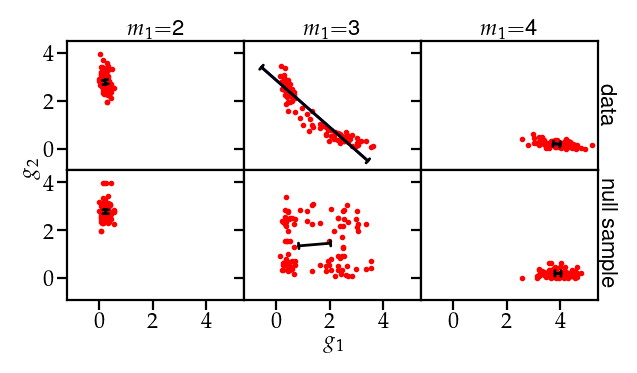

In [9]:
# make the figure

wid = 8.7/2.54
ht  = wid/2

fig,axs=plt.subplots(2,3,figsize=(wid,ht),dpi=200)
ts = [0,bif_idxs[0],-1]
xmin = -1.2
xmax = 5.4
ymin = -0.9
ymax = 4.5

arstls = ['|-|','|-|','|-|']

for i in range(3):



    axs[0,i].plot(gexp[ts[i],:,0],gexp[ts[i],:,1],'ro',markersize=1,zorder=0)
    axs[1,i].plot(gexp_shuf[ts[i],:,0],gexp_shuf[ts[i],:,1],'ro',markersize=1, zorder=0)

    axs[0,i].add_artist(patches.FancyArrowPatch(dat_evec_fi[ts[i]], dat_evec_st[ts[i]],
                                               arrowstyle=arstls[i], mutation_scale=1,zorder=2,
                                                shrinkA=0,shrinkB=0))
    axs[1,i].add_artist(patches.FancyArrowPatch(shuf_evec_st[ts[i]], shuf_evec_fi[ts[i]],
                                               arrowstyle=arstls[i], mutation_scale=1, zorder=2,
                                                shrinkA=0,shrinkB=0))
    axs[0,i].plot(dat_evec_xs[ts[i]],dat_evec_ys[ts[i]],'b-',alpha=1,zorder=1)
    axs[0,i].set_title(bifvarlab+r'$=${0:.0f}'.format(m1s[ts[i]]))
    
    for j in range(2):
        axs[j,i].set_xticks([0,2,4])
        axs[j,i].set_yticks([0,2,4])
        axs[j,i].set_xlim([xmin,xmax])
        axs[j,i].set_ylim([ymin,ymax])

        if j==0:
            axs[j,i].set_xticklabels([])

        if i > 0:
            axs[j,i].set_yticklabels([])

plt.subplots_adjust(wspace=0,hspace=0)
axs[1,1].set_xlabel(r'$g_1$')
axs[1,0].set_ylabel(r'$g_2$')
axs[1,0].yaxis.set_label_coords(-0.15,1)


axs[0,2].set_ylabel('data',rotation=270,labelpad=7)
axs[0,2].yaxis.set_label_position("right")

axs[1,2].set_ylabel('null sample',rotation=270,labelpad=7)
axs[1,2].yaxis.set_label_position("right")

#plt.savefig('{0}/figS4_resample.pdf'.format(figdir), bbox_inches='tight')

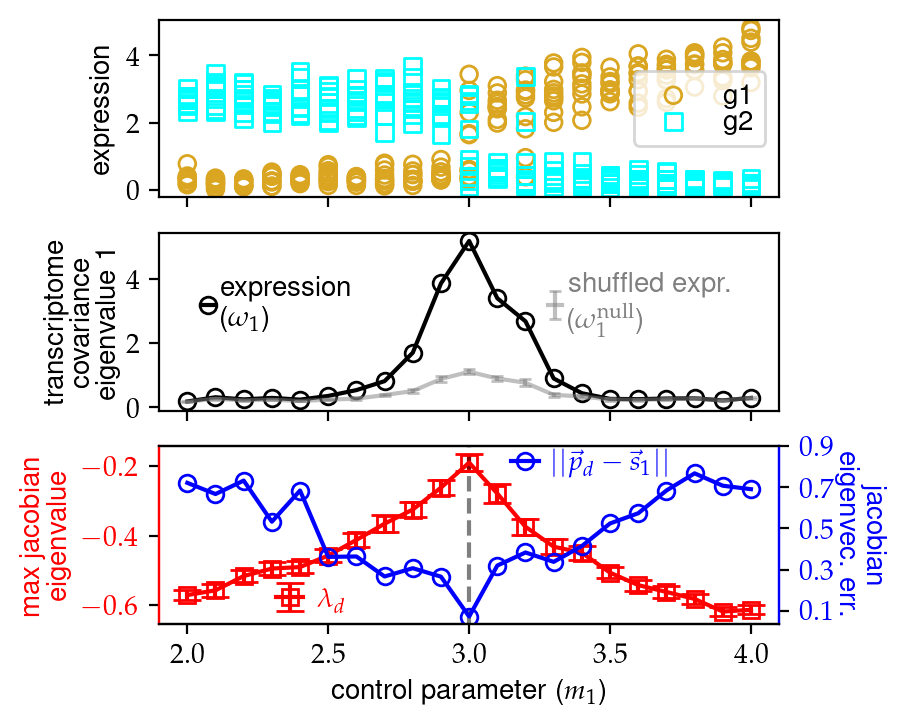

In [40]:
fig,axs=plt.subplots(3,1,figsize=(4,4),dpi=200)
axD=axs[1]
axF1=axs[2]
lspace=1
dm1            = np.mean(np.diff(m1s))

taulims        = [np.min(m1s)-dm1,np.max(m1s)+dm1]
bifvarlab = r'$m_1$'


ncell = 10
for i in range(m1s.shape[0]):
    axs[0].scatter(m1s[i]*np.ones(ncell),gexps[0,i,0:ncell,0],marker='o',facecolor='none',edgecolor='goldenrod', 
                   label='g1' if i==0 else None)
    axs[0].scatter(m1s[i]*np.ones(ncell),gexps[0,i,0:ncell,1],marker='s',facecolor='none',edgecolor='cyan', 
                   label='g2' if i==0 else None)
    #axs[0].scatter(m1s[i]*np.ones(ncell),gexps[0,i,0:ncell,54],marker='o',facecolor='none',edgecolor='green')

axs[0].legend(labelspacing=0, frameon=True)#, labelcolor='markerfacecolor')

axs[0].set_ylabel(r'expression')
    
axs[0].set_xticklabels([])

#####################################
## D: covariance eigenvalue         ##
#####################################
cols = ['k','gray']
axD.plot(m1s, np.real(cov_evals[0,:,0]),'o-', color=cols[0],fillstyle='none', 
         label='expression\n'+r'($\omega_1$)')
axD.set_ylabel(r'$\omega_1$')
axD.set_ylabel('transcriptome\ncovariance\neigenvalue 1',linespacing=lspace,labelpad=2)

axD.set_xticklabels([])
axD.set_yticks(np.arange(0,7,2))
axD.set_xlim(*taulims)
axD.errorbar(m1s, null_eval_mu[:,0], yerr = null_eval_err[:,0], color=cols[1],
             capsize=2,alpha=0.5, 
             label='shuffled expr.\n'+r'($\omega_1^{\rm null}$)')
leg = axD.legend(loc = (0.05,0.35),labelspacing=0,frameon=False,ncol=2,columnspacing=7,
                 handlelength=0.5,handletextpad=0.2)
for i,text in zip(range(len(cols)),leg.get_texts()):
    plt.setp(text, color = cols[i])

#####################################
## F: jacobian evalue / evec       ##
#####################################

axcols = ['r','b']
axF1.errorbar(m1s,mu_jac_max_eval, yerr=std_jac_max_eval, capsize=5, color=axcols[0],
              marker='s', fillstyle='none', label=r'$\lambda_d$')
axF1.set_ylabel('max jacobian\neigenvalue', color=axcols[0], linespacing=lspace)#, labelpad=0)
axF1.tick_params(axis='y', labelcolor=axcols[0])
axF1.spines['left'].set_color(axcols[0])
axF1.spines['right'].set_color(axcols[1])
axF1.set_yticks(np.arange(-0.6,0,0.2))
axF1.set_xlim(*taulims)

axF1.set_xlabel(bifvarlab)
axF1.set_xlabel('control parameter ({0})'.format(bifvarlab))
axF1.axvline(m1s[bif_idxs[0]],color='k', linestyle = '--', alpha=0.5)
leg = axF1.legend(loc=(0.17,0),frameon=False,handlelength=1,handletextpad=0.5)
for text in leg.get_texts():
    text.set_color(axcols[0])

#jacobian eigenvector error
axF2=axF1.twinx()
axF2.plot(m1s, jac_evec_err, 'o-',fillstyle='none',color=axcols[1],label=r'$||\vec{p}_d-\vec{s}_1||$')
axF2.set_ylabel('jacobian\neigenvec. err.',rotation=270,labelpad=19,color=axcols[1],linespacing=lspace)
axF2.tick_params(axis='y', labelcolor=axcols[1])
axF2.spines['left'].set_color(axcols[0])
axF2.spines['right'].set_color(axcols[1])
axF2.set_yticks([0.1,0.3,0.5,0.7,0.9])
leg = axF2.legend(loc=(0.55,0.76),frameon=False,handlelength=1,handletextpad=0.5)
for text in leg.get_texts():
    text.set_color(axcols[1])
plt.show()

In [ ]:
3+4